# Introduction

This notebook demonstrates the new capabilities introduced in `Amazon Titan Image Generator v2`, a powerful tool for generating and manipulating images using text prompts and reference visuals. 

Specifically, in this notebook, we will be focusing on **Image Conditioning** feature, which generates outputs that follow the layout and structure of a user-supplied reference image by providing it along with a text prompt. Two modes are supported:

- Canny Edge: Extract prominent edges from the reference image to guide the generation process.
- Segmentation: Define specific regions/objects within the reference image for the model to generate content aligned with those areas.


# Pre-requisite

Before diving into the code examples, ensure you have the following

- An AWS account with access to Amazon Bedrock

- Enable `Titan Image Generator v2` model access in Amazon Bedrock

- The necessary IAM permissions to invoke Amazon Bedrock models

- AWS SDK for Python (Boto3) installed


In [ ]:
%pip install boto3 numpy pillow matplotlib --quiet

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
import base64
import io
import json
import logging
import boto3
import numpy as np

from PIL import Image
from io import BytesIO
from pathlib import Path
from matplotlib import pyplot as plt

bedrock_runtime_client = boto3.client("bedrock-runtime")

In [ ]:
# Define function for display
def plot_images(ref_image_path, base_images, prompt, seed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    reference_image = Image.open(ref_image_path)
    max_size = (300,300)
    reference_image.thumbnail(max_size)
    
    axes[0].imshow(np.array(reference_image))
    axes[0].set_title('Reference Image\n')
    axes[0].axis('off')

    axes[1].imshow(np.array(base_images[0]))
    axes[1].set_title('Image Generated Based on Reference\nSeed: {}'.format(seed))
    axes[1].axis('off')

    
    print("Prompt:{}\n".format(prompt))
    plt.show()

In [ ]:
# Define function to save the output
def save_image(base64_image, output_file):
    image_bytes = base64.b64decode(base64_image)
    image = Image.open(io.BytesIO(image_bytes))
    image.save(output_file)

### Image Conditioning

Image conditioning allows users to guide image creation using a reference image. It supports two modes:

##### 1. Canny Edge

Canny edge uses edges from the reference image to guide structure and layout of the image

In [ ]:
# Define the prompt, reference image and  path to store the generated images
prompt = "a cartoon deer in a fairy world"
reference_image_path = "Data/deer.png"
seed = 50 # Can be any random number between 0 to 214783647

# Create output folder and specify output path
Path("Output/").mkdir(parents=True, exist_ok=True)
output_save_path = "Output/cartoon_deer.png" 

Prompt:a cartoon deer in a fairy world



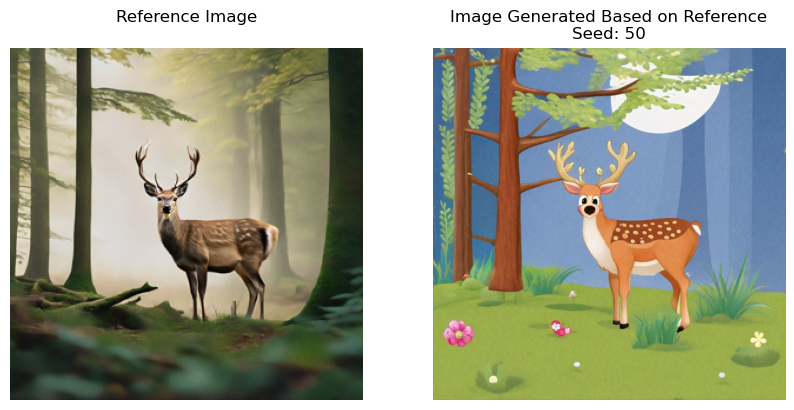

In [5]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "CANNY_EDGE", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(reference_image_path, response_images, prompt, seed)

##### 2. Segmentation

Segmentation uses segmented regions from the reference image to control placement of specific elements

In [ ]:
# Define the prompt, reference image and path to store the generated images
prompt = "car in driveway during sunset time"
reference_image_path = "Data/car_house.png"
seed = 50 # Can be any random number between 0 to 214783647

output_save_path = "Output/car_house_sunset.png" 

Prompt:car in driveway during sunset time



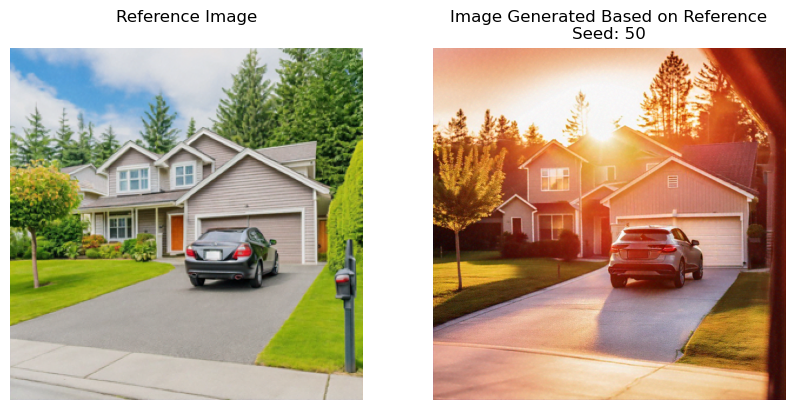

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "SEGMENTATION", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = bedrock_runtime_client.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(reference_image_path, response_images, prompt, seed)

# Take Away

Amazon Titan Image Generator v2 introduces advanced features such as image conditioning, color conditioning and background removal, enhacing the capabilities of AI-driven image generation. 

We encourage users to explore these new functionalities within Amazon Bedrock to experience the expanded potential for creating precise, customized visual contents.